In [5]:
from __future__ import division
import numpy as np
import pandas as pd
import lims_utils
#import layer_counts.layer_counts as lc
from PIL import Image
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import allensdk.core.swc as swc
import io
from multiprocessing import Pool
import glob
import os
import json
import matplotlib.path as mplPath
#from morph_features.morph_features.features import natural_sort_key

import argparse
from PIL import Image

with open(r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\subset_processing\mouse_m1_me_and_met_avg_layer_depths.json') as j:
    layer_depths = json.load(j)
#     

In [7]:
import re

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)]

In [8]:
swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\cell_types_card\la_swc'
outdir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\cell_types_card\combo'
#outdir = r'/Users/alice/neuron_morphology_scripts/cell_types_card/cards'

contrast_level = 0.65

NODE_ID = 'id'
NODE_TYPE = 'type'
NODE_X = 'x'
NODE_Y = 'y'
NODE_Z = 'z'
NODE_R = 'radius'
NODE_PN = 'parent'
SWC_COLUMNS = [NODE_ID, NODE_TYPE, NODE_X, NODE_Y, NODE_Z, NODE_R, NODE_PN]

In [9]:
def to_dict(swc_file):
    nodes = {}
    with open(swc_file, "r") as f:
        for line in f:
            if line.lstrip().startswith('#'):
                continue
            toks = line.split()
            node_dict = {
                'id' : int(toks[0]),
                'type' : int(toks[1]),
                'x' : float(toks[2]),
                'y' : float(toks[3]),
                'z' : float(toks[4]),
                'radius' : float(toks[5]),
                'parent' : int(toks[6].rstrip())
            }
            nodes[int(toks[0])] = node_dict
    return nodes


def dict_to_Morphology(neuron_dict):
    """
    Takes a neuron dictionary and converts to a Morphology
    """
    nodes = []
    for vals in neuron_dict.values():
        new_node = swc.Compartment({
            NODE_ID: vals['id'],
            NODE_TYPE: vals['type'],
            NODE_X: vals['x'],
            NODE_Y: vals['y'],
            NODE_Z: vals['z'],
            NODE_R: vals['radius'],
            NODE_PN: vals['parent']}
        )
        nodes.append(new_node)
    return swc.Morphology(compartment_list=nodes)#, strict_validation=False)

def shift(x, y, z, morpho):
	for node in morpho.keys():
		morpho[node]['x'] += x
		morpho[node]['y'] += y
		morpho[node]['z'] += z
		
	return morpho

In [10]:
#sps_info = pd.read_csv('/Users/alice/neuron_morphology_scripts/tolias_m1/v1/M1_V1_cell_info++.csv')
sps_info = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\subset_processing\m1_patchseq_meta_data.csv', sep='\t')
sps_info = sps_info[['Cell', 'RNA type']]
sps_info.rename(columns = {'Cell':'specimen_id'}, inplace = True)

In [11]:
histogram_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\cell_types_card\histogram.csv')
histogram_df['specimen_id'] = [t[:-10] for t in histogram_df['specimen_id']]


In [12]:
merged_histogram = histogram_df.merge(sps_info,left_on='specimen_id',right_on='specimen_id')


all_cols_mouse = sorted(histogram_df.columns, key=natural_sort_key)
ax_cols = sorted([c for c in merged_histogram.columns if c.startswith('2_')],key=natural_sort_key)
basal_dend_cols = sorted([c for c in merged_histogram.columns if c.startswith('3_')],key=natural_sort_key)
apical_dend_cols = sorted([c for c in merged_histogram.columns if c.startswith('4_')],key=natural_sort_key)
columns_dict = {'apical':apical_dend_cols,'basal':basal_dend_cols,'axon':ax_cols}

In [13]:
def sroot(m):
    """ Returns root node of soma, if present"""
    if len(m._tree_list) > 0 and m._tree_list[0][0]['type'] == 1:
        return m._tree_list[0][0]
    return None

In [24]:
sps = []
la_depths = []
missing_sps = []
for sp in merged_histogram.specimen_id:
    #print(sp)
    sps.append(sp)
    #la_morph = '/Users/alice/neuron_morphology_scripts/tolias_m1/v1/v1_final_hist/{}_pruned.swc_connected_smoothed_marked_fixed.swc'.format(sp)
    la_morph = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\cell_types_card\la_swc\{}_fixed.swc'.format(sp)
    try:
        morpho = swc.read_swc(la_morph)
        la_d = abs(sroot(morpho)['y'])
        la_depths.append(la_d)
    except:
        print(sp, 'bad:', la_morph)
        la_depths.append(np.nan)
        missing_sps.append(sp)
    
depths_df = pd.DataFrame({'specimen_id':sps,'layer_aligned_depth':la_depths})
merged_histogram = merged_histogram.merge(depths_df,left_on='specimen_id',right_on='specimen_id')

In [25]:
merged_histogram.columns

Index([u'Unnamed: 0', u'2_L1_0_5', u'2_L1_5_10', u'2_L1_10_15', u'2_L1_15_20',
       u'2_L1_20_25', u'2_L1_25_30', u'2_L1_30_35', u'2_L1_35_40',
       u'2_L1_40_45',
       ...
       u'23_L6_970_975', u'23_L6_975_980', u'23_L6_980_985', u'23_L6_985_990',
       u'23_L6_990_995', u'specimen_id', u'RNA type', u'layer_aligned_depth_x',
       u'layer_aligned_depth_y', u'layer_aligned_depth'],
      dtype='object', length=790)

In [17]:
color_dict = {'L5 ET_1' : '#0d5d7e', 'L5 ET_2': '#2686af', 'L5 ET_3': '#3aa1b6', 'L5 ET_4': '#0a75b1' , 'Pvalb Vipr2_2': '#f4358b' }

In [18]:
# META DATA

meta = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\subset_processing\m1_patchseq_meta_data.csv', sep='\t')

cells = meta['Cell'].values

layers = meta['Targeted layer'].values.astype('str')
cre  = meta['Cre'].values
yields = meta['Yield (pg/µl)'].values
yields[yields=='?'] = np.nan
yields = yields.astype('float')
depth = meta['Soma depth (µm)'].values
depth[depth=='Slice Lost'] = np.nan
depth = depth.astype(float)
thickness = meta['Cortical thickness (µm)'].values
thickness[thickness==0] = np.nan
thickness = thickness.astype(float)
traced = meta['Traced'].values=='y'
exclude = meta['Exclusion reasons'].values.astype(str)
exclude[exclude=='nan'] = ''

mice_names = meta['Mouse'].values
mice_ages = meta['Mouse age'].values
mice_cres = np.array([c if c[-1]!='+' and c[-1]!='-' else c[:-1] for c in meta['Cre'].values])
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print('Number of cells with measured depth:    ', np.sum(~np.isnan(depth)))
print('Number of cells with measured thickness:', np.sum(~np.isnan(thickness)))
print('Number of reconstructed cells:          ', np.sum(traced))

sliceids = meta['Slice'].values
a,b = np.unique(sliceids, return_counts=True)
assert np.all(b<=2)
print('Number of slices with two cells:        ', np.sum(b==2))

# Some consistency checks
assert np.all([np.unique(meta['Date'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse age'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse gender'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse genotype'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse'].values[sliceids==s]).size==1 for s in sliceids])

('Number of cells with measured depth:    ', 1284)
('Number of cells with measured thickness:', 1284)
('Number of reconstructed cells:          ', 646)
('Number of slices with two cells:        ', 69)


In [19]:

def find_cols(hex_color, spiny):
    
    hex_color = hex_color[1:len(hex_color)]
    main_col_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    secondary_col_rgb = tuple([int((contrast_level*x)) for x in main_col_rgb])

    main_col_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    secondary_col_rgb = tuple([int((contrast_level*x)) for x in main_col_rgb])
    grey_rgb = tuple([125,125,125,255]) 
    white_rgb = tuple([255,255,255,255])

    main_col_rgb_morph = main_col_rgb + (255,)
    secondary_col_rgb_morph = secondary_col_rgb + (255,)

    main_col_rgba = tuple([(float(x/255)) for x in main_col_rgb_morph])
    secondary_col_rgba = tuple([( float(x/255)) for x in secondary_col_rgb_morph])
    grey_rgba = tuple([( float(x/255)) for x in grey_rgb])
    white_rgba = tuple([( float(x/255)) for x in white_rgb])
    
    if spiny:
        color_dict = {3: main_col_rgba, 4: main_col_rgba, 2:main_col_rgba}
    else:
        color_dict = {3: secondary_col_rgba, 4: white_rgba, 2:main_col_rgba} 
                
    return color_dict

In [21]:
from os.path import join
#ref_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1'
# color_dat =  pd.read_csv(join(ref_dir, 'cluster.annotation.csv'))
# clusterColors = dict(zip(color_dat.cluster_label, color_dat.cluster_color))

cluster_dat = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\tolias_m1\subset_processing\m1_patchseq_meta_data.csv', sep='\t')
cluster_dat = cluster_dat[['Cell', 'RNA type']]


In [26]:
import seaborn as sns
inh = ['20190214_sample_1', '20190619_sample_5' ]

uniq_labels = sorted(merged_histogram['specimen_id'].unique())

contrast_level = 0.45

for sp in uniq_labels:
    print(sp)
    
    if sp in inh:
        spiny = False
    else:
        spiny = True
    
    
    this_sp = merged_histogram[merged_histogram['specimen_id']==sp]   
    ttype = this_sp.iloc[0]['RNA type']
    col = color_dict[ttype]
    from matplotlib import gridspec

    fig = plt.figure()
    fig.set_size_inches(3.5,5)
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                             width_ratios=[2, 1])
    spec.update(wspace=0, hspace=0)

    #make morpho
    #fig, axes = plt.subplots(1, 2, sharey=True, figsize=(4.25,3.5))


    #fig1 = plt.gcf()
    ax1 = fig.add_subplot(spec[0])
    mdict = to_dict(join(swc_dir, sp + '_fixed.swc'))
    morph = dict_to_Morphology(mdict)
    morph_colors = find_cols(col, spiny)
    side = False
    xoffset = 0

    for compartment, color in morph_colors.items():
        #print compartment
        #print color
        lines_x = []
        lines_y = []
        for c in morph.compartment_list_by_type(compartment):
            if c["parent"] == -1:
                continue
            p = morph.compartment_index[c["parent"]]
            if side:
                lines_x += [p["z"] + xoffset, c["z"] + xoffset, None]
            else:
                lines_x += [p["x"] + xoffset, c["x"] + xoffset, None]
            lines_y += [p["y"], c["y"], None]
        #lines_y = [None if v is None else -1*v for v in lines_y]
        lines_y = [None if v is None else v for v in lines_y]
        ax1.plot(lines_x, lines_y, c=color, linewidth=1, zorder=compartment)
        ax1.set_aspect("equal",share=True)
        ax1.axis('off')

    #fig.set_size_inches(4.25,3.5)
    img_path = os.path.join(outdir,'{}.png'.format(sp))
    ax1.axhline(0, linewidth = 2, c="lightgrey")
    #ax.axhline(0, c="blueviolet")
    for v in layer_depths.values():
        ax1.axhline(v, linewidth = 2, c="lightgrey")
        
    ax1.scatter(morph.soma['x'],abs(morph.soma['y']),c='k',s=1,zorder=100)
    #ax1.set_xlim()
    #ax = plt.gca()
    ax1.set_ylim(ax1.get_ylim()[::-1])
    #plt.savefig(img_path,dpi=300,bbox_inches='tight')


    #histogram

    #ax2 = axes[1]
    ax2 = fig.add_subplot(spec[1], sharey=ax1)

    axon_rgb = (tuple(int(col[1:][i:i+2], 16) for i in (0, 2, 4))) 
    axon_std = axon_rgb + (105,)
    axon_rgba = tuple([(x/float(255)) for x in axon_std])

    
    plt.yticks([])
    plt.setp(ax2.spines.values(), linewidth=2)
    sns.despine(ax=ax2, right = True, left = False)

    #fig.suptitle(sp,y=0.98)

    #outfile = '/Users/alice/neuron_morphology_scripts/cell_types_card/hist/{}.png'.format(sp)

    #col_ct = 0


    soma_depths = this_sp['layer_aligned_depth'].values
    soma_xs = np.zeros(len(soma_depths))

    row_ct=-1
    for label in ['axon', 'apical','basal']:
        label_columns = columns_dict[label]
        if label == 'axon' and not spiny:
            col = morph_colors[2]
        else:
            col = morph_colors[3]
            #print ('changing colors')
            
        #row_ct+=1
        #ax = plt.gca()
        ax2.set_ylim(0,1000)
        if spiny:
            ### as micron axis label
            ax2.set_xlim(0, 50)
            plt.xticks([0, 25, 50])
        else:
            ax2.set_xlim(0, 100)
            plt.xticks([0, 50, 100])
            
            
        plt.xlabel('μm')

        ax2.invert_yaxis()
        #ax.set_title("{} (n={})".format(label,len(this_tt)))
        this_sp_compart = this_sp[label_columns]
        average_line = this_sp_compart.mean().values
        sem = this_sp_compart.sem().values

        lower_bound = average_line-sem
        upper_bound = average_line+sem
        lower_bound[lower_bound==0]=np.nan
        upper_bound[upper_bound==0]=np.nan
        average_line[average_line==0] = np.nan


        #ax2.fill_betweenx(np.arange(len(this_sp_compart.values.mean(axis=0))) * 5,lower_bound*1000,
        #         upper_bound*10000,color=axon_rgba)
        ax2.fill_betweenx(np.arange(len(this_sp_compart.values.mean(axis=0))) * 5,average_line,
            np.zeros(len(this_sp_compart.values.mean(axis=0))),color=col)
        #ax2.fill(average_line, np.arange(this_sp_compart.values.shape[1]) * 5, c = col)
        #ax2.plot(average_line, np.arange(this_sp_compart.values.shape[1]) * 5., lw=2,c=col)
        ax2.axhline(0, linewidth=3, c="k")
        
        for v in layer_depths.values():
            ax2.axhline(v, linewidth = 2, c="k")

        for axis in ['top','bottom', 'right']:
              ax2.spines[axis].set_linewidth(2)
        #ax2.scatter(soma_xs,soma_depths,facecolors='none', edgecolors='k')



    fig.savefig(join(outdir, sp + '.png'),dpi=300,bbox_inches='tight')
    #plt.clf()

20171207_sample_2


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 1050x1500 with 2 Axes>

_______________________________________________________________________________________


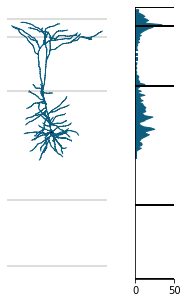

In [134]:
sp = '20171207_sample_2'
this_sp = merged_histogram[merged_histogram['specimen_id']==sp]   
ttype = this_sp.iloc[0]['RNA type']
col = color_dict[ttype]
from matplotlib import gridspec

fig = plt.figure()
fig.set_size_inches(3.5,5)
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[4, 1])
spec.update(wspace=0, hspace=0)

#make morpho
#fig, axes = plt.subplots(1, 2, sharey=True, figsize=(4.25,3.5))


#fig1 = plt.gcf()
ax1 = fig.add_subplot(spec[0])
mdict = to_dict(join(swc_dir, sp + '_fixed.swc'))
morph = dict_to_Morphology(mdict)
morph_colors = find_cols(col, True)
side = False
xoffset = 0

for compartment, color in morph_colors.items():
    #print compartment
    #print color
    lines_x = []
    lines_y = []
    for c in morph.compartment_list_by_type(compartment):
        if c["parent"] == -1:
            continue
        p = morph.compartment_index[c["parent"]]
        if side:
            lines_x += [p["z"] + xoffset, c["z"] + xoffset, None]
        else:
            lines_x += [p["x"] + xoffset, c["x"] + xoffset, None]
        lines_y += [p["y"], c["y"], None]
    #lines_y = [None if v is None else -1*v for v in lines_y]
    lines_y = [None if v is None else v for v in lines_y]
    ax1.plot(lines_x, lines_y, c=color, linewidth=1, zorder=compartment)
    ax1.set_aspect("equal",share=True)
    ax1.axis('off')

#fig.set_size_inches(4.25,3.5)
img_path = os.path.join(outdir,'{}.png'.format(sp))
ax1.axhline(0, c="lightgrey")
#ax.axhline(0, c="blueviolet")
for v in layer_depths.values():
    ax1.axhline(v, c="lightgrey")
ax1.scatter(morph.soma['x'],abs(morph.soma['y']),c='k',s=1,zorder=100)
#ax1.set_xlim()
#ax = plt.gca()
ax1.set_ylim(ax1.get_ylim()[::-1])
#plt.savefig(img_path,dpi=300,bbox_inches='tight')


#histogram

#ax2 = axes[1]
ax2 = fig.add_subplot(spec[1])

axon_rgb = (tuple(int(col[1:][i:i+2], 16) for i in (0, 2, 4))) 
axon_std = axon_rgb + (105,)
axon_rgba = tuple([(x/float(255)) for x in axon_std])

#plt.xticks([])
plt.yticks([])
sns.despine(ax=ax2, right = True, left = False, top = False, bottom = False)

#fig.suptitle(sp,y=0.98)

#outfile = '/Users/alice/neuron_morphology_scripts/cell_types_card/hist/{}.png'.format(sp)

#col_ct = 0


soma_depths = this_sp['layer_aligned_depth'].values
soma_xs = np.zeros(len(soma_depths))

row_ct=-1
for label in ['apical','basal','axon']:
    label_columns = columns_dict[label]
    #row_ct+=1
    #ax = plt.gca()
    ax2.set_ylim(0,1000)
    ax2.set_xlim(0, 50)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax2.invert_yaxis()
    #ax.set_title("{} (n={})".format(label,len(this_tt)))
    this_sp_compart = this_sp[label_columns]
    average_line = this_sp_compart.mean().values
    sem = this_sp_compart.sem().values

    lower_bound = average_line-sem
    upper_bound = average_line+sem
    lower_bound[lower_bound==0]=np.nan
    upper_bound[upper_bound==0]=np.nan
    average_line[average_line==0] = np.nan


    ax2.fill_betweenx(np.arange(len(this_sp_compart.values.mean(axis=0))) * 5,average_line,
             np.zeros(len(this_sp_compart.values.mean(axis=0))),color=col)

    #ax2.fill(average_line, np.arange(this_sp_compart.values.shape[1]) * 5, c = col)
    #ax2.plot(average_line, np.arange(this_sp_compart.values.shape[1]) * 5., lw=2,c=col)
    ax2.axhline(0, c="k")
    for v in layer_depths.values():
        ax2.axhline(v, c="k")

    #ax2.scatter(soma_xs,soma_depths,facecolors='none', edgecolors='k')



fig.savefig(join(outdir, sp + '.png'),dpi=300,bbox_inches='tight')
print('_______________________________________________________________________________________')
#plt.clf()

In [104]:
for c in layer_depths.keys():
    print c, layer_depths[c]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(c, layer_depths[c])? (<ipython-input-104-247a1500c952>, line 2)